# Comparison of Face Detection Algorithms

## Objective
In this first part of the third assignment, you will test different face detection algorithms as made available in Python through OpenCV, DLib or other Deep Learning packages.
Since a dataset (Caltech) with ground truth bounding box coordinates has been made available, you can evaluate the output of the detectors through some overlap measures.

## Guidelines and code support
You can follow the [Learn OpenCV tutorial on Face Detection](https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/) for some (very coarse) background info and (more importantly) code snippets for two "conventional" (HAAR-cascade, HOG) CV methods and two Deep Neural Net (Dlib) based (SSD, MMOD) methods. 

When using the [Download Code link](https://bigvisionllc.leadpages.net/leadbox/143948b73f72a2%3A173c9390c346dc/5649050225344512/) on that page, you will be downloading the Python/C++ code for all the tutorials. You just need to (re-)use the FaceDetectionComparison subdirectory for the relevant code.

As far as I can tell, the face detector in the very concise [face_recognition package](https://face-recognition.readthedocs.io/en/latest/index.html) comes in 2 flavours: HOG and MMOD. This package is developed by Adam Geitgey on top of the DLib library developed by Davis King. It has a very convenient interface to face detection and recognition modules (see later) and can thus be substituted for the Dlib based code parts. 

## Understand the methods
Please study the relevant publications on these detectors to understand their functioning. 

* Some background on Haar, HOG and MMOD face detectors can be found in this [Guide to Face Detection in Python](https://towardsdatascience.com/a-guide-to-face-detection-in-python-3eab0f6b9fc1). 

* For MMOD specifically, see: [Max-Margin Object Detection by Davis E. King](http://arxiv.org/abs/1502.00046) and the comments at the beginning of the [dnn_mmod_ex.cpp code](https://github.com/davisking/dlib/blob/master/examples/dnn_mmod_ex.cpp).

* For further info on the Single-Shot-Multibox Detector, see [the arXiv publication](https://arxiv.org/abs/1512.02325).

* For the face_recognition package some info (for the face recognition part at least) can be found [here](https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78).

You can summarize the methods inside the notebook if you wish. 



## Implement and Validate
Apply these 4 techniques to the CALTECH Faces Dataset. You can re-use code made available by the packages listed previously. 

Show some results (e.g. a la the run-all.py module) to appreciate qualitively. 

You can then quantitatively evaluate the results by comparing the returned locations to the ground truth locations and validate the algorithms as such. 

Think about ways to measure the detection results. 

Guidelines (and python code) can be found in: 
* [the face detection comparison tutorial](https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/), more specifically (section 5) the issues of using a reasonable overlap measure (AP_50). 
* [general object detection validation - Cartucho](https://github.com/Cartucho/mAP)
* [general object detection validation - Padilla](https://github.com/rafaelpadilla/Object-Detection-Metrics)
* [mean Average Precision - Hui](https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173)
* [mean Average Precision - Arlen](https://medium.com/@timothycarlen/understanding-the-map-evaluation-metric-for-object-detection-a07fe6962cf3)

## OpenCV Haar

In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import cv2
import time
import sys
from localmodules.datasets import load_faces
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

In [3]:
def detectFaceOpenCVHaar(faceCascade, frame, inHeight=300, inWidth=0):
    frameOpenCVHaar = frame.copy()
    frameHeight = frameOpenCVHaar.shape[0]
    frameWidth = frameOpenCVHaar.shape[1]
    if not inWidth:
        inWidth = int((frameWidth / frameHeight) * inHeight)

    scaleHeight = frameHeight / inHeight
    scaleWidth = frameWidth / inWidth

    frameOpenCVHaarSmall = cv2.resize(frameOpenCVHaar, (inWidth, inHeight))
    
    frameGray = cv2.cvtColor(frameOpenCVHaarSmall, cv2.COLOR_BGR2GRAY)

    faces = faceCascade.detectMultiScale(frameGray)
    bboxes = []
    for (x, y, w, h) in faces:
        x1 = x
        y1 = y
        x2 = x + w
        y2 = y + h
        cvRect = [int(x1 * scaleWidth), int(y1 * scaleHeight),
                  int(x2 * scaleWidth), int(y2 * scaleHeight)]
        bboxes.append(cvRect)
        cv2.rectangle(frameOpenCVHaar, (cvRect[0], cvRect[1]), (cvRect[2], cvRect[3]), (0, 255, 0),
                      int(round(frameHeight / 150)), 4)
    return frameOpenCVHaar, bboxes

In [4]:
faceCascade = cv2.CascadeClassifier('./FaceDetectionComparison/models/haarcascade_frontalface_default.xml')
caltechDataset = Path("./CalTechFacesDirs")
faces, bb = load_faces("CALTECH", dataset = caltechDataset, min_faces=10, max_targets=50)

In [5]:
print(np.array(bb).shape)
print(faces.images.shape)

(445, 8)
(445, 592, 896, 3)


In [6]:
def bb_intersection_over_union(boxA, boxB):

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

(592, 896, 3)


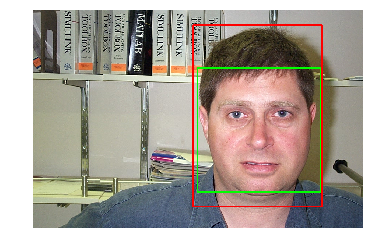

[[446, 157, 781, 493]]
(435, 41, 784, 533)
0.6562271805273834
445


In [7]:
# print(type(faces.images[0]))
# plt.imshow(faces.images[0], cmap='gray')
# plt.show()
b = bb[0]
im = faces.images[0]
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
outOpencvHaar, bboxes = detectFaceOpenCVHaar(faceCascade, im)
cv2.rectangle(outOpencvHaar, (b[2], b[3]), (b[6], b[7]), (255,0, 0), 4)
print(outOpencvHaar.shape)
plt.imshow(outOpencvHaar, cmap='gray')
plt.axis('off')
plt.show()
print(bboxes)
print((b[2], b[3], b[6], b[7]))
print(bb_intersection_over_union(bboxes[0], (b[2], b[3], b[6], b[7])))

haar_bboxes = []
for i in range(len(faces.images)):
    outImage, bboxes = detectFaceOpenCVHaar(faceCascade, faces.images[i])
    haar_bboxes.append(bboxes)
print(len(haar_bboxes))

## Dlib HOG

In [8]:
import dlib

In [9]:
def detectFaceDlibHog(detector, frame, inHeight=300, inWidth=0):

    frameDlibHog = frame.copy()
    frameHeight = frameDlibHog.shape[0]
    frameWidth = frameDlibHog.shape[1]
    if not inWidth:
        inWidth = int((frameWidth / frameHeight)*inHeight)

    scaleHeight = frameHeight / inHeight
    scaleWidth = frameWidth / inWidth

    frameDlibHogSmall = cv2.resize(frameDlibHog, (inWidth, inHeight))

    frameDlibHogSmall = cv2.cvtColor(frameDlibHogSmall, cv2.COLOR_BGR2RGB)
    faceRects = detector(frameDlibHogSmall, 0)
#     print(frameWidth, frameHeight, inWidth, inHeight)
    bboxes = []
    for faceRect in faceRects:

        cvRect = [int(faceRect.left()*scaleWidth), int(faceRect.top()*scaleHeight),
                  int(faceRect.right()*scaleWidth), int(faceRect.bottom()*scaleHeight) ]
        bboxes.append(cvRect)
        cv2.rectangle(frameDlibHog, (cvRect[0], cvRect[1]), (cvRect[2], cvRect[3]), (0, 255, 0), int(round(frameHeight/150)), 4)
    return frameDlibHog, bboxes

[[483, 236, 728, 483]]


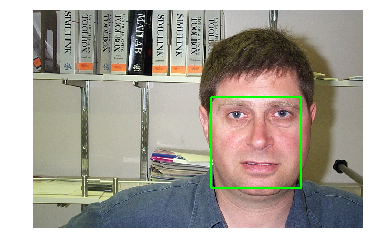

445


In [10]:
hogFaceDetector = dlib.get_frontal_face_detector()
outDlibHog, bboxes = detectFaceDlibHog(hogFaceDetector,im)
print(bboxes)
plt.imshow(outDlibHog, cmap='gray')
plt.axis('off')
plt.show()

hog_bboxes = []
for i in range(len(faces.images)):
    outDlibHog, bboxes = detectFaceDlibHog(hogFaceDetector, faces.images[i])
    hog_bboxes.append(bboxes)
print(len(hog_bboxes))

## DNN OpenCV - Single-Shot-Multibox detector

In [11]:
def detectFaceOpenCVDnn(net, frame):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], False, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv2.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes

In [12]:
modelFile = "./FaceDetectionComparison/models/opencv_face_detector_uint8.pb"
configFile = "./FaceDetectionComparison/models/opencv_face_detector.pbtxt"
net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)

# conf_threshold = 0.7
conf_threshold = 0.999

[[479, 160, 748, 498]]


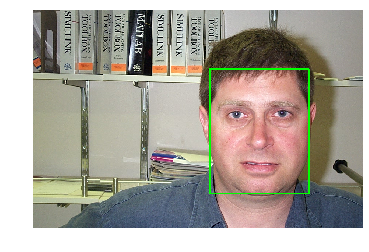

445


In [13]:
outOpencvDnn, bboxes = detectFaceOpenCVDnn(net,im)
print(bboxes)
plt.imshow(outOpencvDnn, cmap='gray')
plt.axis('off')
plt.show()

ssmd_bboxes = []
for i in range(len(faces.images)):
    outOpencvDnn, bboxes = detectFaceOpenCVDnn(net, faces.images[i])
    ssmd_bboxes.append(bboxes)
print(len(ssmd_bboxes))

## DNN Dlib - Maximum-Margin Object Detector (MMOD)

In [14]:
def detectFaceDlibMMOD(detector, frame, inHeight=300, inWidth=0):

    frameDlibMMOD = frame.copy()
    frameHeight = frameDlibMMOD.shape[0]
    frameWidth = frameDlibMMOD.shape[1]
    if not inWidth:
        inWidth = int((frameWidth / frameHeight)*inHeight)

    scaleHeight = frameHeight / inHeight
    scaleWidth = frameWidth / inWidth

    frameDlibMMODSmall = cv2.resize(frameDlibMMOD, (inWidth, inHeight))

    frameDlibMMODSmall = cv2.cvtColor(frameDlibMMODSmall, cv2.COLOR_BGR2RGB)
    faceRects = detector(frameDlibMMODSmall, 0)

#     print(frameWidth, frameHeight, inWidth, inHeight)
    bboxes = []
    for faceRect in faceRects:
        cvRect = [int(faceRect.rect.left()*scaleWidth), int(faceRect.rect.top()*scaleHeight),
                  int(faceRect.rect.right()*scaleWidth), int(faceRect.rect.bottom()*scaleHeight) ]
        bboxes.append(cvRect)
        cv2.rectangle(frameDlibMMOD, (cvRect[0], cvRect[1]), (cvRect[2], cvRect[3]), (0, 255, 0), int(round(frameHeight/150)), 4)
    return frameDlibMMOD, bboxes

In [15]:
dnnFaceDetector = dlib.cnn_face_detection_model_v1("./mmod_human_face_detector.dat")

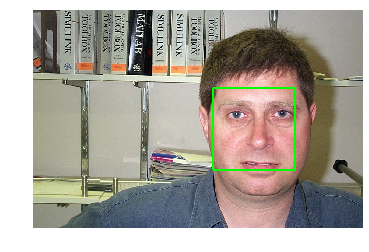

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [18]:
outDlibMMOD, bboxes = detectFaceDlibMMOD(dnnFaceDetector,im)
plt.imshow(outDlibMMOD, cmap='gray')
plt.axis('off')
plt.show()

mmod_bboxes = []
for i in range(len(faces.images)):
    print(i)
    outDlibMMOD, bboxes = detectFaceDlibMMOD(dnnFaceDetector, faces.images[i])
    mmod_bboxes.append(bboxes)
print(len(mmod_bboxes))

In [19]:
def get_IoU(b_true, b_pred):
    values = []
    for i in range(len(b_true)):
        try:
            boxA = (b_true[i][2],b_true[i][3],b_true[i][6],b_true[i][7])

            boxB = b_pred[i][0]
            values.append(bb_intersection_over_union(boxA, boxB))
        except:
            print('no face found')
            values.append(0)
    
    return (sum(values)/len(values))

In [20]:
haar_IoU = get_IoU( bb,haar_bboxes)

no face found


In [21]:
print(haar_IoU)

0.5493303278894528


In [22]:
hog_IoU = get_IoU( bb,hog_bboxes)
ssmd_IoU = get_IoU( bb,ssmd_bboxes)
mmod_IoU = get_IoU( bb,mmod_bboxes)

no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no face found
no fac

In [23]:
print(hog_IoU)

0.43935087185779836


In [24]:
print(ssmd_IoU)

0.43158459055254905


In [25]:
print(mmod_IoU)

0.39142004501961036


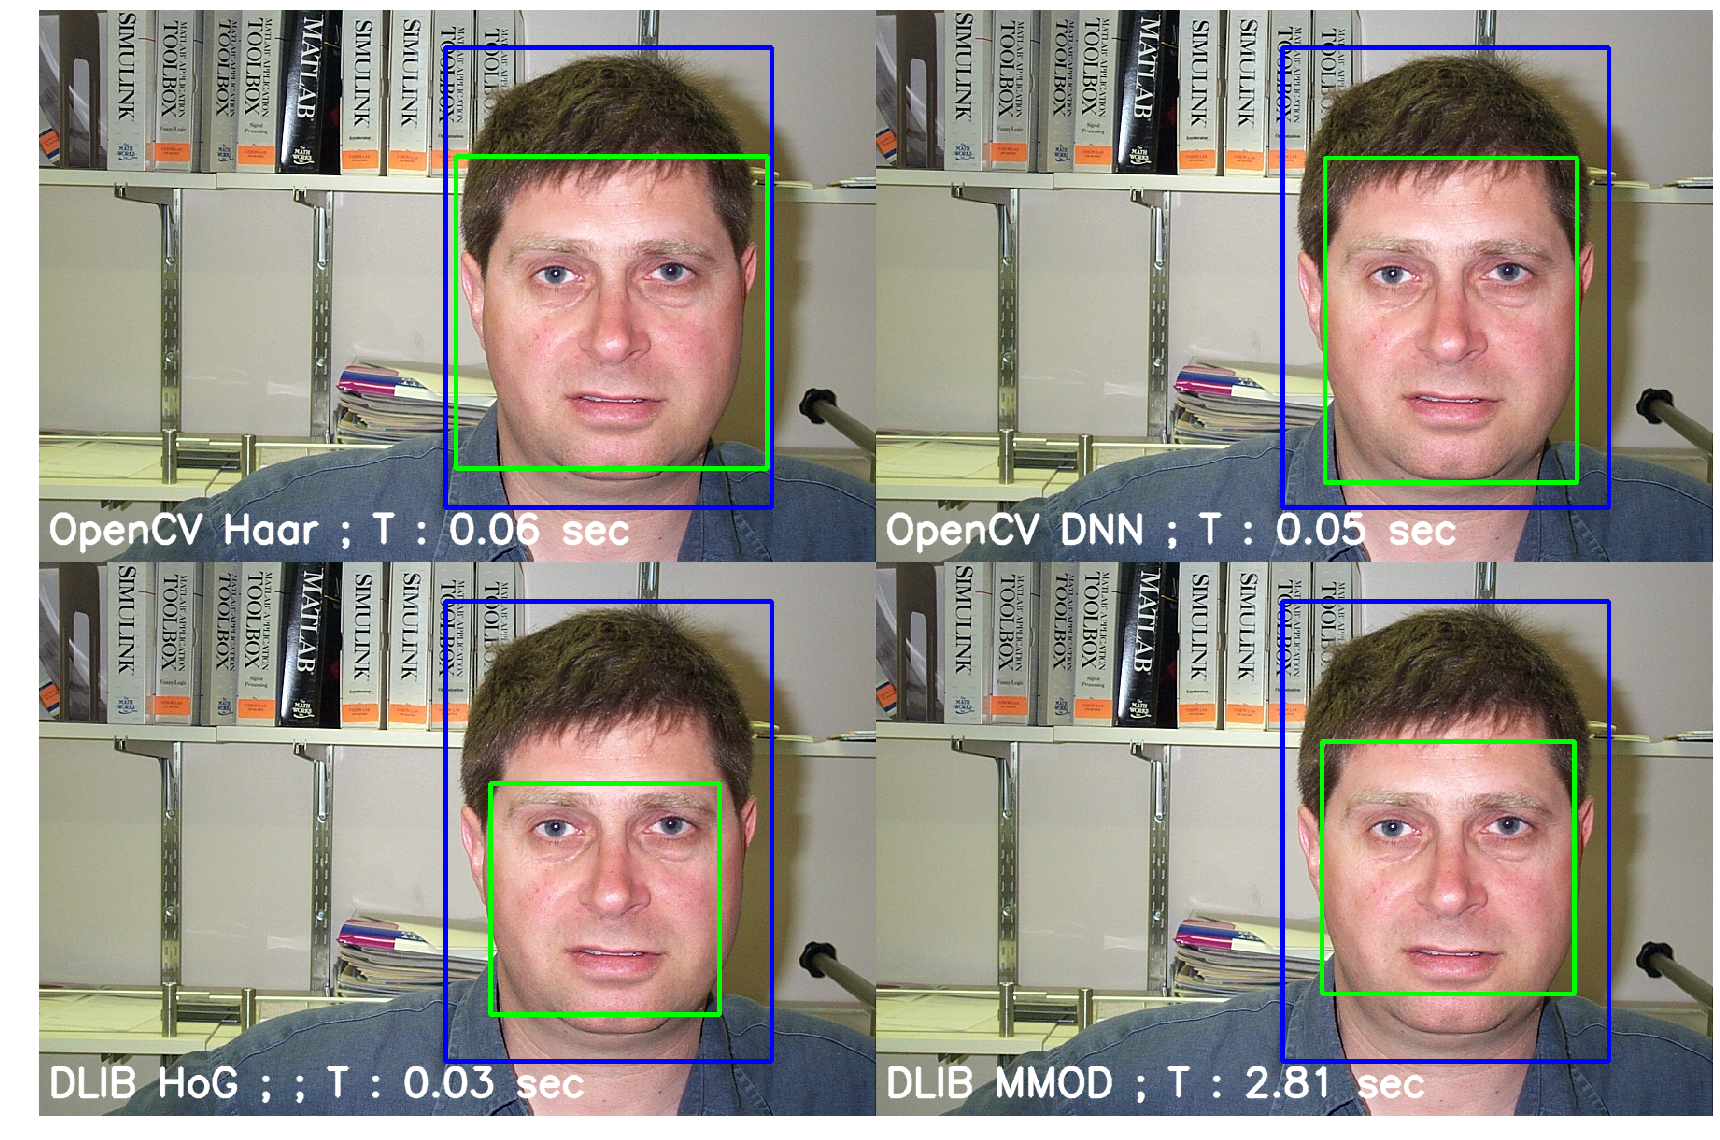

In [45]:
import time

frame = faces.images[0]

t = time.time()
outOpencvHaar, bboxes = detectFaceOpenCVHaar(faceCascade, frame)
tt_opencvHaar = time.time() - t
cv2.rectangle(outOpencvHaar, (b[2], b[3]), (b[6], b[7]), (255,0, 0), 4)

label = "OpenCV Haar ; T : {:.2f} sec".format(tt_opencvHaar)
cv2.putText(outOpencvHaar, label, (10, 570), cv2.FONT_HERSHEY_SIMPLEX, 1.4, (255,255, 255), 3, cv2.LINE_AA)

t = time.time()
outOpencvDnn, bboxes = detectFaceOpenCVDnn(net,frame)
tt_opencvDnn = time.time() - t
cv2.rectangle(outOpencvDnn, (b[2], b[3]), (b[6], b[7]), (255,0, 0), 4)

label = "OpenCV DNN ; T : {:.2f} sec".format(tt_opencvDnn)
cv2.putText(outOpencvDnn, label, (10,570), cv2.FONT_HERSHEY_SIMPLEX, 1.4, (255, 255, 255), 3, cv2.LINE_AA)

t = time.time()
outDlibHog, bboxes = detectFaceDlibHog(hogFaceDetector,frame)
tt_dlibHog = time.time() - t
cv2.rectangle(outDlibHog, (b[2], b[3]), (b[6], b[7]), (255,0, 0), 4)


label = "DLIB HoG ; ; T : {:.2f} sec".format(tt_dlibHog)
cv2.putText(outDlibHog, label, (10, 570), cv2.FONT_HERSHEY_SIMPLEX, 1.4, (255, 255, 255), 3, cv2.LINE_AA)

t = time.time()
outDlibMMOD, bboxes = detectFaceDlibMMOD(dnnFaceDetector,frame)
tt_dlibMmod = time.time() - t
cv2.rectangle(outDlibMMOD, (b[2], b[3]), (b[6], b[7]), (255,0, 0), 4)

label = "DLIB MMOD ; T : {:.2f} sec".format(tt_dlibMmod)
cv2.putText(outDlibMMOD, label, (10, 570), cv2.FONT_HERSHEY_SIMPLEX, 1.4, (255,255,255), 3, cv2.LINE_AA)

top = np.hstack([outOpencvHaar, outOpencvDnn])
bottom = np.hstack([outDlibHog, outDlibMMOD])
combined = np.vstack([top, bottom])
fig, ax = plt.subplots(figsize=(30, 30))
ax.axis('off')
ax.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))